In [3]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.special import softmax
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data,HeteroData
from torch_geometric.utils import to_networkx,degree
import networkx as nx
def create_hetero_data(path_hetero_data):
    '''
    Input:
        path_hetero_data: str, path to the file containing the heterogeneous data
    '''
    if path_hetero_data[-1] != '/':
        path_hetero_data += '/'
    accounts = pd.read_csv(path_hetero_data + 'accounts.csv')
    features = pd.read_csv(path_hetero_data + 'features.csv')
    transactions = pd.read_csv(path_hetero_data + 'transactions.csv')
    
    data = HeteroData()
    
    idx_internal = accounts['internal'] == True
    idx_external = ~idx_internal
    
    # Create separate mappings for internal and external node IDs
    internal_ids = accounts['account_id'][idx_internal].values
    external_ids = accounts['account_id'][idx_external].values
    
    internal_id_map = {old_id: new_id for new_id, old_id in enumerate(internal_ids)}
    external_id_map = {old_id: new_id for new_id, old_id in enumerate(external_ids)}
    
    # Apply the mapping to node IDs
    internal_mapped_ids = [internal_id_map[account_id] for account_id in accounts['account_id'][idx_internal]]
    external_mapped_ids = [external_id_map[account_id] for account_id in accounts['account_id'][idx_external]]
    
    data['internal'].id = torch.tensor(internal_mapped_ids, dtype=torch.int64)
    data['external'].id = torch.tensor(external_mapped_ids, dtype=torch.int64)
    
    # Set node features and labels
    data['internal'].x = torch.tensor(features[idx_internal].values, dtype=torch.float32)
    data['external'].x = torch.tensor(features[idx_external].values, dtype=torch.float32)
    
    data['internal'].y = torch.tensor(accounts['label'][idx_internal].values, dtype=torch.int64)
    
    # Set the num_nodes attribute
    data['internal'].num_nodes = len(internal_mapped_ids)
    data['external'].num_nodes = len(external_mapped_ids)
    
    # Remap the sender and receiver IDs in transactions
    transactions['sender_mapped'] = transactions.apply(
        lambda row: internal_id_map[row['sender']] if row['sender'] in internal_id_map else external_id_map[row['sender']], axis=1)
    transactions['receiver_mapped'] = transactions.apply(
        lambda row: internal_id_map[row['receiver']] if row['receiver'] in internal_id_map else external_id_map[row['receiver']], axis=1)
    
    # Create edge indices using the new contiguous IDs
    data['internal', 'internal_txn', 'internal'].edge_index = torch.tensor(transactions[['sender_mapped', 'receiver_mapped']].loc[transactions.txn_type == 0].values.T, dtype=torch.long)
    data['internal', 'external_withdraw', 'external'].edge_index = torch.tensor(transactions[['sender_mapped', 'receiver_mapped']].loc[transactions.txn_type == 1].values.T, dtype=torch.long)
    data['external', 'external_deposit', 'internal'].edge_index = torch.tensor(transactions[['sender_mapped', 'receiver_mapped']].loc[transactions.txn_type == 2].values.T, dtype=torch.long)
    
    # Create train, val, test masks
    _labels = np.where(data['internal'].y<2)[0]
    # num_nodes = node_features.size(0)
    num_internal_nodes = len(_labels)
    
    # Randomly shuffle the internal node IDs
    # 70% train, 15% val, 15% test
    np.random.seed(0)
    train_mask = np.random.choice(_labels, int(0.7 * num_internal_nodes), replace=False)
    val_mask = np.random.choice(np.setdiff1d(_labels, train_mask), int(0.15 * num_internal_nodes), replace=False)
    test_mask = np.setdiff1d(_labels, np.concatenate([train_mask, val_mask]))
    
    train_mask_tensor = torch.zeros(data['internal'].x.size(0), dtype=torch.bool)
    val_mask_tensor = torch.zeros(data['internal'].x.size(0), dtype=torch.bool)
    test_mask_tensor = torch.zeros(data['internal'].x.size(0), dtype=torch.bool)
    
    train_mask_tensor[train_mask] = True
    val_mask_tensor[val_mask] = True
    test_mask_tensor[test_mask] = True
    
    data['internal'].train_mask = train_mask_tensor
    data['internal'].val_mask = val_mask_tensor
    data['internal'].test_mask = test_mask_tensor
    
    return data

In [4]:
hetero_data = create_hetero_data('hetero_data/elliptic/ext_0.4')
homo_data = hetero_data.to_homogeneous()

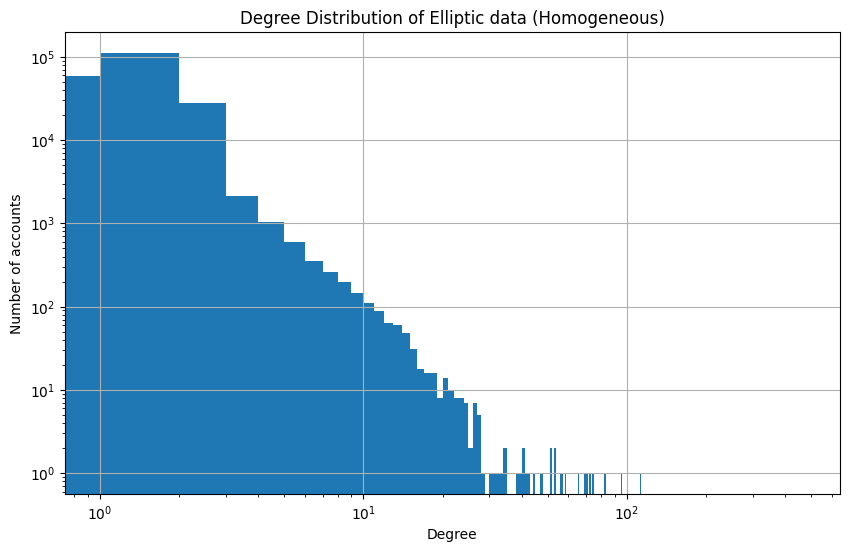

In [5]:
# Check the degree distributions (homogeneous) 
deg_homo = degree(homo_data.edge_index[0],num_nodes=homo_data.num_nodes)
plt.figure(figsize=(10, 6))
plt.hist(deg_homo.numpy(), bins=range(int(deg_homo.numpy().max() + 1)), density=False)
plt.title('Degree Distribution of Elliptic data (Homogeneous)')

plt.xlabel('Degree')
plt.ylabel('Number of accounts')
plt.xscale('log')
plt.yscale('log')  # Optionally use logarithmic scale for better visibility
plt.grid(True)
plt.show()

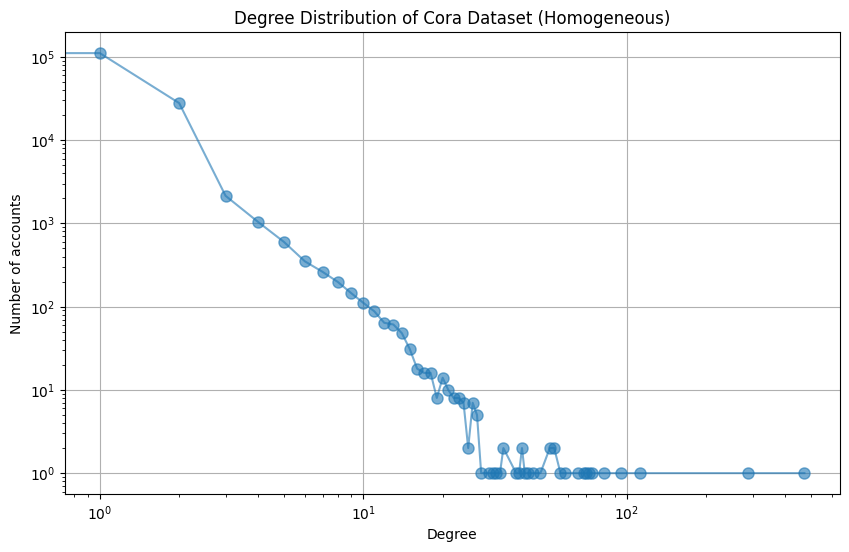

In [6]:
# Check the degree distributions (homogeneous)
deg_homo = degree(homo_data.edge_index[0],num_nodes=homo_data.num_nodes)
degrees, counts = torch.unique(deg_homo, return_counts=True)

# Plot degree distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(degrees.numpy(), counts.numpy(), alpha=0.6, marker='o', linestyle='-', markersize=8)
plt.title('Degree Distribution of Cora Dataset (Homogeneous)')
plt.xlabel('Degree')
plt.ylabel('Number of accounts')
plt.xscale('log')
plt.yscale('log')  # Optionally use logarithmic scale for better visibility
plt.grid(True)
plt.show()

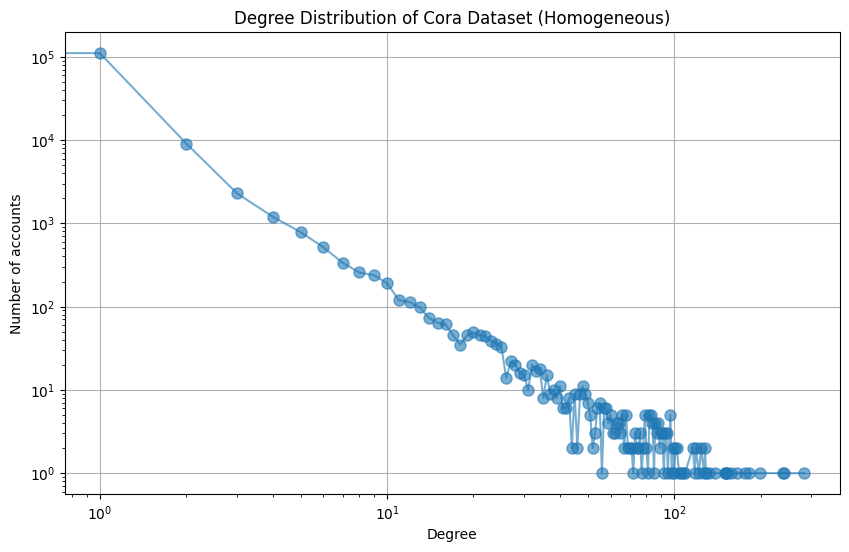

In [41]:
# Check the out degree distributions (homogeneous)
deg_homo = degree(homo_data.edge_index[1],num_nodes=homo_data.num_nodes)
degrees, counts = torch.unique(deg_homo, return_counts=True)

# Plot degree distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(degrees.numpy(), counts.numpy(), alpha=0.6, marker='o', linestyle='-', markersize=8)
# plt.title('Degree Distribution of Cora Dataset (Homogeneous)')
plt.xlabel('Degree')
plt.ylabel('Number of accounts')
plt.xscale('log')
plt.yscale('log')  # Optionally use logarithmic scale for better visibility
plt.grid(True)
plt.show()

In [27]:
# Assuming homo_data is your homogeneous graph data
np.random.seed(42)

# Calculate the number of nodes to sample
portion = 0.05
num_nodes = homo_data.num_nodes
num_sampled_nodes = int(portion * num_nodes)

# Sample nodes
sampled_node_indices = np.random.choice(num_nodes, num_sampled_nodes, replace=False)

# Create a mask for the sampled nodes
sampled_node_mask = torch.zeros(num_nodes, dtype=torch.bool)
sampled_node_mask[sampled_node_indices] = True

from torch_geometric.utils import subgraph

# Extract the subgraph using the sampled nodes
sampled_edge_index, edge_mask = subgraph(sampled_node_mask, homo_data.edge_index, relabel_nodes=True, num_nodes=num_nodes)

# Extract the node and edge attributes for the subgraph
sampled_node_type = homo_data.node_type[sampled_node_mask]
sampled_edge_type = homo_data.edge_type[edge_mask]

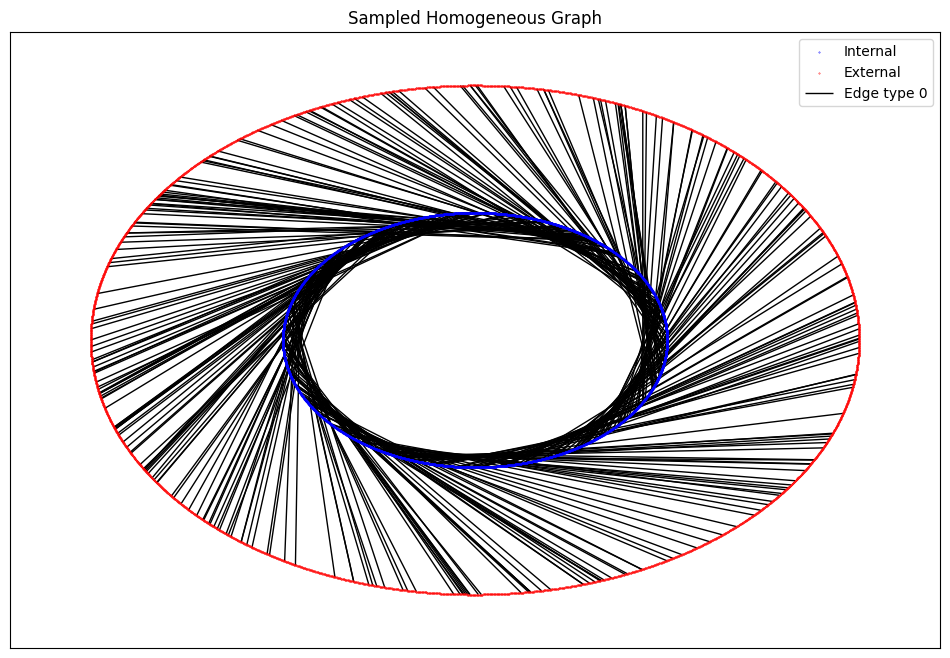

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Create a NetworkX graph from the sampled subgraph
G = nx.Graph()

# Add nodes with their attributes
for i, node in enumerate(sampled_node_indices):
    G.add_node(i, node_type=sampled_node_type[i].item())

# Add edges with their attributes
for i in range(sampled_edge_index.shape[1]):
    u = sampled_edge_index[0, i].item()
    v = sampled_edge_index[1, i].item()
    edge_type = sampled_edge_type[0][i].item()
    G.add_edge(u, v, edge_type=edge_type)

# Get positions for the nodes in G
# pos = nx.drawing.bipartite_layout(G,[n for n, d in G.nodes(data=True) if d['node_type'] == 0])
pos = nx.drawing.shell_layout(G,[[n for n, d in G.nodes(data=True) if d['node_type'] == 0],
                                 [n for n, d in G.nodes(data=True) if d['node_type'] == 1]
                                 ])

# Plotting
plt.figure(figsize=(12, 8))

# Get unique node types
node_types = sampled_node_type.unique().tolist()

# Draw nodes by type
color_map = {0: 'blue', 1: 'red'}  # Adjust colors based on your node types

for node_type in node_types:
    nodes = [n for n, d in G.nodes(data=True) if d['node_type'] == node_type]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=0.1, node_color=color_map[node_type], label='Internal' if node_type == 0 else 'External')

# Get unique edge types
edge_types = sampled_edge_type.unique().tolist()

# Draw edges by type
for edge_type in edge_types:
    edges = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == edge_type]
    nx.draw_networkx_edges(G, pos, edgelist=edges, label=f'Edge type {edge_type}')

plt.legend()
plt.title('Sampled Homogeneous Graph')
plt.show()

In [14]:
pos

{0: array([0.67239505, 0.76183176]),
 1: array([-0.83518863, -0.64062595]),
 2: array([-0.34573546, -0.87213069]),
 3: array([-0.42713752, -0.84620917]),
 4: array([ 0.28547594, -0.96968645]),
 5: array([ 0.76253837, -0.63465333]),
 6: array([0.42927727, 0.77351093]),
 7: array([-0.88732684,  0.14633076]),
 8: array([0.13206701, 0.02869478]),
 9: array([-0.2022641 ,  0.92704445]),
 10: array([ 0.77335793, -0.68818468]),
 11: array([-0.84649372,  0.40564808]),
 12: array([-0.17956915, -0.94971412]),
 13: array([-0.80284524,  0.62696952]),
 14: array([ 0.22014207, -0.86109966]),
 15: array([0.56772906, 0.76270854]),
 16: array([-0.05267656, -0.9175424 ]),
 17: array([-0.60012734, -0.74759525]),
 18: array([ 0.23960066, -0.82504129]),
 19: array([-0.78696406,  0.35577738]),
 20: array([ 0.1816985 , -0.93006814]),
 21: array([-0.12006404, -0.98874438]),
 22: array([ 0.67402852, -0.70092273]),
 23: array([0.85507584, 0.57409704]),
 24: array([ 0.3585057 , -0.85788441]),
 25: array([-0.99945

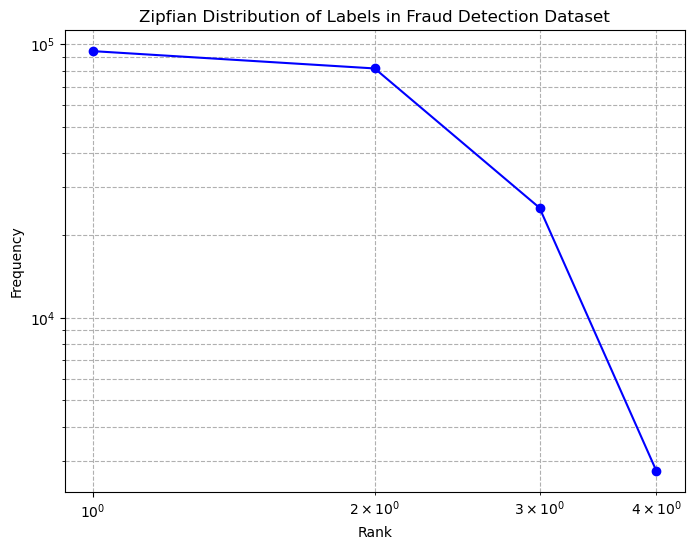

In [90]:
import torch

# Assuming homo_data is your homogeneous graph data
labels, label_counts = torch.unique(homo_data.y, return_counts=True)

# Sort labels by their frequency in descending order
sorted_indices = torch.argsort(label_counts, descending=True)
sorted_labels = labels[sorted_indices]
sorted_label_counts = label_counts[sorted_indices]

import matplotlib.pyplot as plt

# Plot Zipfian distribution for labels
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(sorted_label_counts) + 1), sorted_label_counts.tolist(), marker='o', linestyle='-', color='blue')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Zipfian Distribution of Labels in Fraud Detection Dataset')
plt.grid(True, which="both", ls="--")
plt.show()

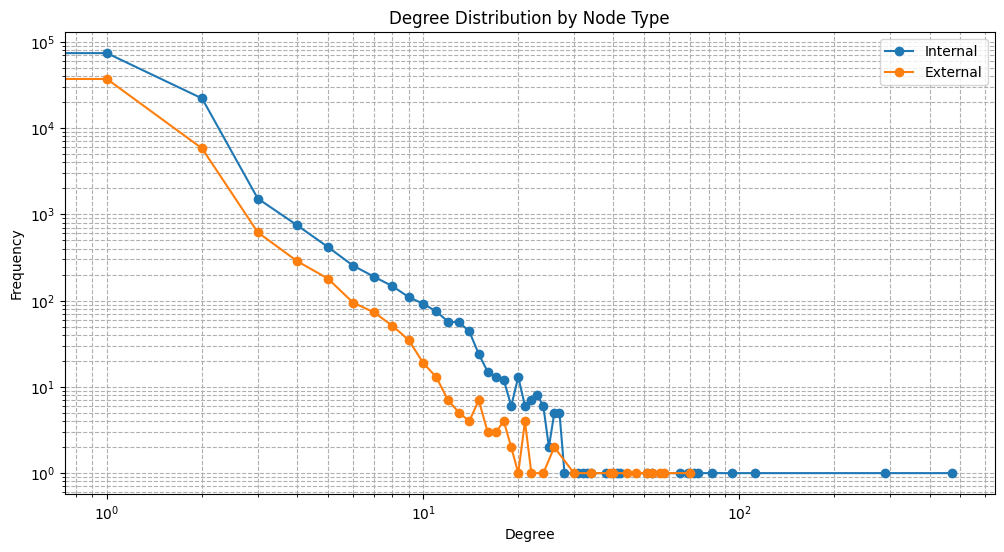

In [40]:
# The degree distribution of different node types
# Calculate degrees
node_degrees = degree(homo_data.edge_index[0], num_nodes=homo_data.num_nodes)

# Get unique node types
node_types = homo_data.node_type.unique().tolist()

# Separate degrees by node type
degrees_by_type = {node_type: [] for node_type in node_types}
for node_index, node_type in enumerate(homo_data.node_type):
    degrees_by_type[node_type.item()].append(node_degrees[node_index].item())

# Convert to tensors for easier manipulation
degrees_by_type = {node_type: torch.tensor(degrees) for node_type, degrees in degrees_by_type.items()}

# Plot degree distributions for each node type
plt.figure(figsize=(12, 6))

for node_type, degrees in degrees_by_type.items():
    unique_degrees, degree_counts = torch.unique(degrees, return_counts=True)
    plt.plot(unique_degrees.numpy(), degree_counts.numpy(), marker='o', linestyle='-', label='Internal' if node_type == 0 else 'External')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution by Node Type')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

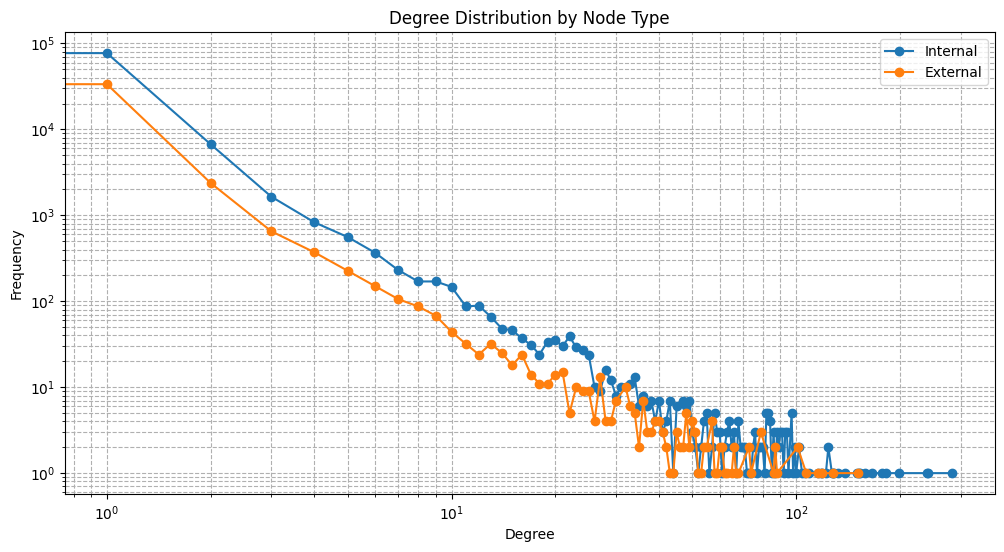

In [39]:
# The degree distribution of different node types
# Calculate degrees
node_degrees = degree(homo_data.edge_index[1], num_nodes=homo_data.num_nodes)

# Get unique node types
node_types = homo_data.node_type.unique().tolist()

# Separate degrees by node type
degrees_by_type = {node_type: [] for node_type in node_types}
for node_index, node_type in enumerate(homo_data.node_type):
    degrees_by_type[node_type.item()].append(node_degrees[node_index].item())

# Convert to tensors for easier manipulation
degrees_by_type = {node_type: torch.tensor(degrees) for node_type, degrees in degrees_by_type.items()}

# Plot degree distributions for each node type
plt.figure(figsize=(12, 6))

for node_type, degrees in degrees_by_type.items():
    unique_degrees, degree_counts = torch.unique(degrees, return_counts=True)
    plt.plot(unique_degrees.numpy(), degree_counts.numpy(), marker='o', linestyle='-', label='Internal' if node_type == 0 else 'External')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution by Node Type')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [42]:
# # Calculate the statistics
# # Convert PyTorch Geometric data to NetworkX graph
# G = to_networkx(homo_data, to_undirected=True)  # or to_undirected=False if your graph is directed

# # Node-level statistics
# node_degrees = degree(homo_data.edge_index[0], num_nodes=homo_data.num_nodes)
# clustering_coefficients = nx.clustering(G)
# betweenness_centrality = nx.betweenness_centrality(G)
# degree_centrality = nx.degree_centrality(G)
# eigenvector_centrality = nx.eigenvector_centrality(G)

# # Edge-level statistics
# edge_betweenness_centrality = nx.edge_betweenness_centrality(G)

# # Graph-level statistics
# density = nx.density(G)
# avg_clustering_coefficient = nx.average_clustering(G)
# if nx.is_connected(G):
#     avg_shortest_path_length = nx.average_shortest_path_length(G)
#     diameter = nx.diameter(G)
# else:
#     avg_shortest_path_length = None
#     diameter = None

# # Component-level statistics
# connected_components = [len(c) for c in nx.connected_components(G)]
# if nx.is_directed(G):
#     strongly_connected_components = [len(c) for c in nx.strongly_connected_components(G)]
# else:
#     strongly_connected_components = None

# # Print the statistics
# print(f"Node Degrees: {node_degrees}")
# print(f"Clustering Coefficients: {clustering_coefficients}")
# print(f"Betweenness Centrality: {betweenness_centrality}")
# print(f"Degree Centrality: {degree_centrality}")
# print(f"Eigenvector Centrality: {eigenvector_centrality}")
# print(f"Edge Betweenness Centrality: {edge_betweenness_centrality}")
# print(f"Density: {density}")
# print(f"Average Clustering Coefficient: {avg_clustering_coefficient}")
# print(f"Average Shortest Path Length: {avg_shortest_path_length}")
# print(f"Diameter: {diameter}")
# print(f"Connected Components: {connected_components}")
# print(f"Strongly Connected Components: {strongly_connected_components}")

In [56]:
edge_types[0][1]

'internal_txn'

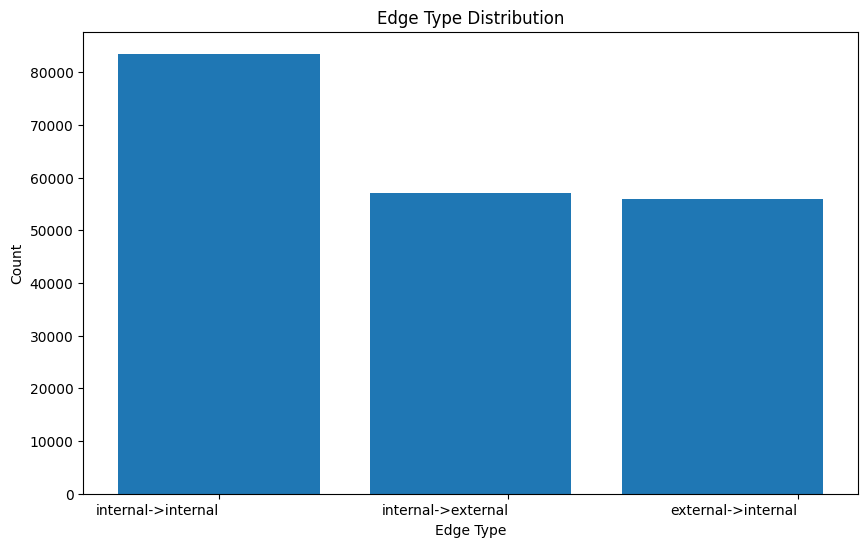

In [73]:
edge_type_counts = {edge_type: 0 for edge_type in hetero_data.edge_types}

# Count the number of edges for each edge type
for edge_type in hetero_data.edge_types:
    edge_index = hetero_data[edge_type].edge_index
    edge_type_counts[edge_type] = edge_index.size(1)  # Number of edges for this type

# Plot the edge type distribution
edge_types = list(edge_type_counts.keys())
counts = list(edge_type_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(range(len(edge_types)), counts,)
plt.xticks(np.arange(len(edge_types))*1.15, [str(et[0])+'->'+str(et[2]) for et in edge_types], rotation=0, ha='right')
plt.xlabel('Edge Type')
plt.ylabel('Count')
plt.title('Edge Type Distribution')
# plt.grid(True, which="both", ls="--")
plt.show()

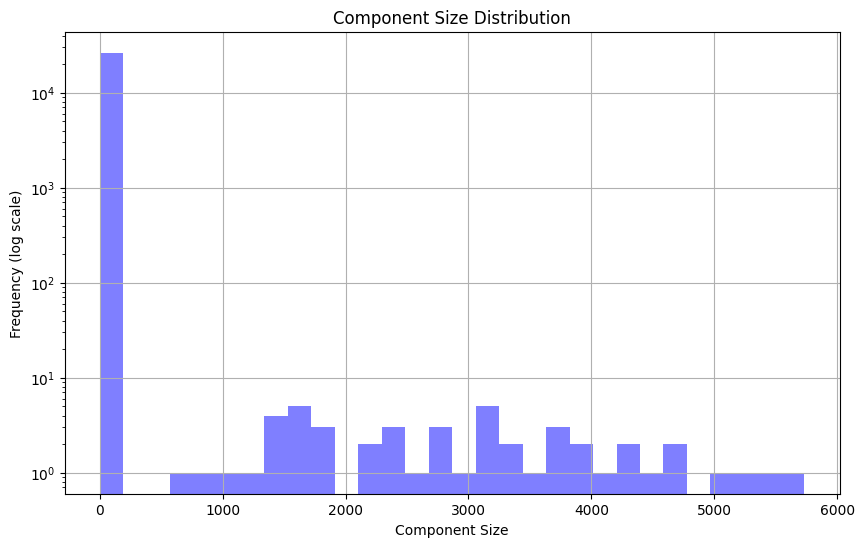

In [76]:
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert the heterogeneous graph to a NetworkX graph
G = to_networkx(homo_data, to_undirected=True)

# Calculate the size of connected components
component_sizes = [len(c) for c in nx.connected_components(G)]

# Plot component size distribution
plt.figure(figsize=(10, 6))
plt.hist(component_sizes, bins=30, log=True, color='blue', alpha=0.5)
plt.xlabel('Component Size')
plt.ylabel('Frequency (log scale)')
plt.title('Component Size Distribution')
plt.grid(True)
plt.show()